In [1]:
import torch
from torchvision import transforms

from vars.loading_data import ChessDB as DB
from vars.model import ConvolutionalNetwork
from vars.utilities import *
import pytorch_lightning as pl
from sklearn.metrics import classification_report


In [2]:
PATH = "./Data/Chess/"
CSV_PATH =  "./Data/"
BATCH = 32
device = torch.device("cpu")

In [3]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
# datloader
data = DB( directory=PATH ,transform=transform, batch_size=32)
print(data.labels)
print(len(data))
print(data.dir_list)

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
1191
['./Data/Chess/Bishop', './Data/Chess/King', './Data/Chess/Knight', './Data/Chess/Pawn', './Data/Chess/Queen', './Data/Chess/Rook']


                    image_path   class
0    ./Data/Chess/Bishop/1.jpg  Bishop
1   ./Data/Chess/Bishop/10.jpg  Bishop
2  ./Data/Chess/Bishop/100.jpg  Bishop
3  ./Data/Chess/Bishop/101.jpg  Bishop
4  ./Data/Chess/Bishop/102.jpg  Bishop


<Figure size 1000x400 with 0 Axes>

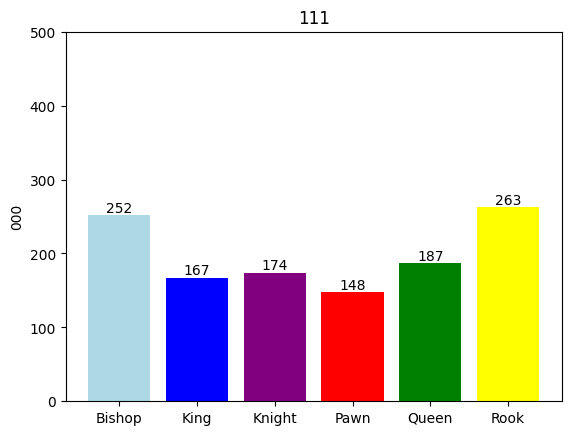

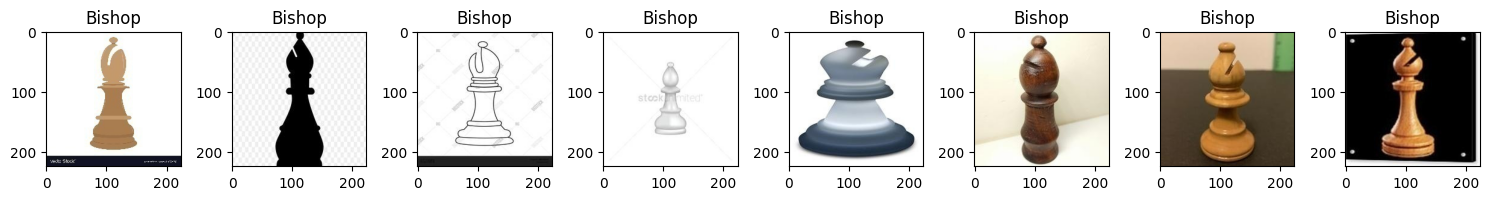

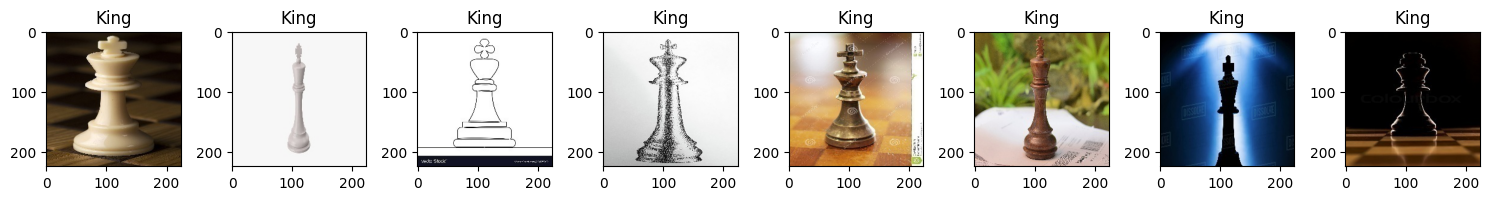

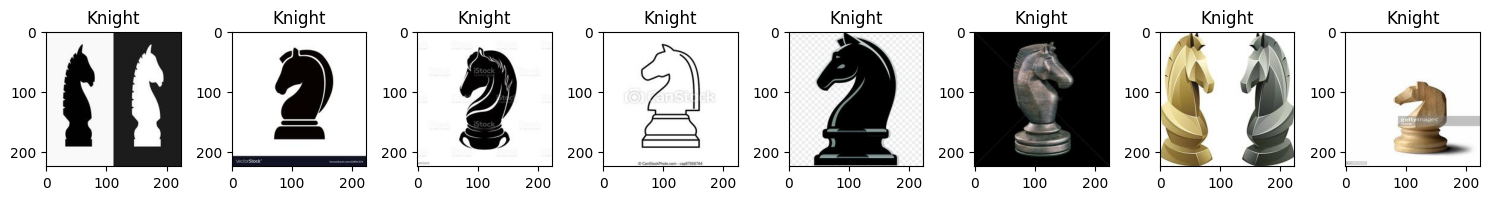

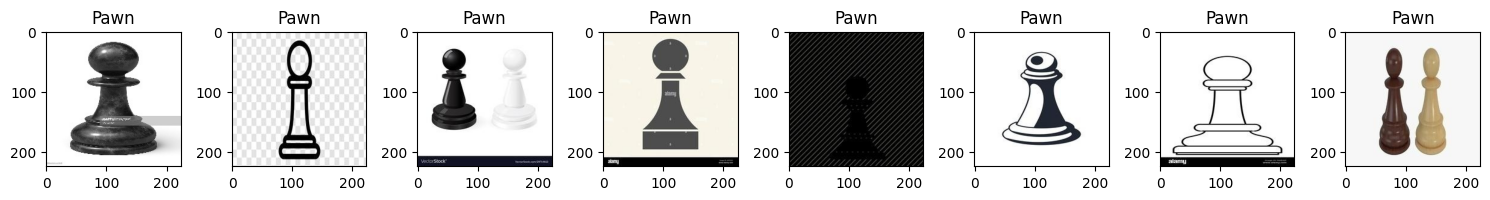

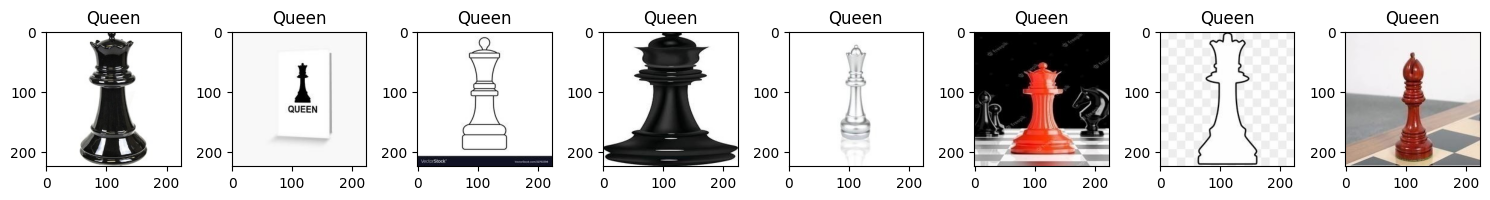

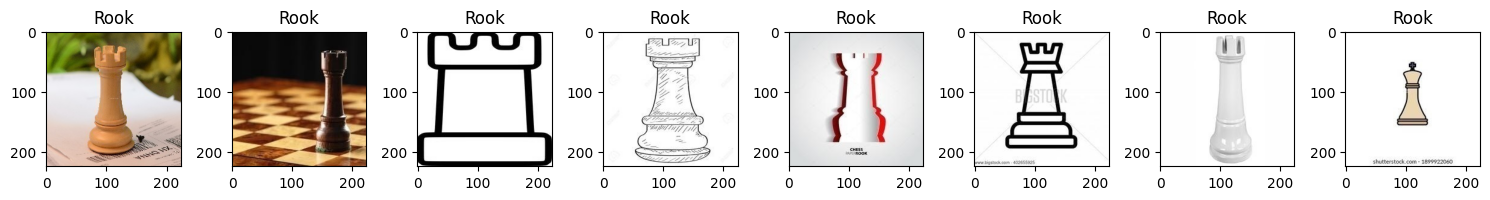

In [5]:
# util
create_CSV(dir=data.dir, out_dir=CSV_PATH)
plot_bar(data.dir,data.labels)
plot_img(dir_list=data.dir_list, labels= data.labels)
# pre_process(dir_list=data.dir_list)


238 715 238


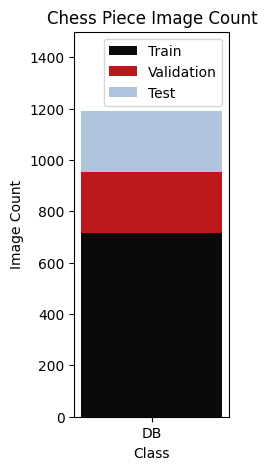

In [6]:
# dataloader
data.db_split(train_ratio=0.6, valid_ratio=0.2, test_ratio=0.2)
trainDB = data.train_dataloader()
validDB = data.valid_dataloader()
testDB = data.test_dataloader()

In [7]:
# model
model = ConvolutionalNetwork(data.labels)
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, data)
data.setup(stage='valid')
valid_loader = data.valid_dataloader()
trainer.validate(dataloaders=valid_loader)
data.setup(stage='test')
test_loader = data.test_dataloader()
trainer.test(dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 126   
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Epoch 49: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 23/23 [00:04<00:00,  5.59it/s, v_num=13]

/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/s5602288/SE/s5602288_Software_Eng/lightning_logs/version_13/checkpoints/epoch=49-step=1150.ckpt


Loaded model weights from the checkpoint at /home/s5602288/SE/s5602288_Software_Eng/lightning_logs/version_13/checkpoints/epoch=49-step=1150.ckpt
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 14.84it/s]

/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/s5602288/SE/s5602288_Software_Eng/lightning_logs/version_13/checkpoints/epoch=49-step=1150.ckpt



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.5630252361297607
        val_loss             3.256317138671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Loaded model weights from the checkpoint at /home/s5602288/SE/s5602288_Software_Eng/lightning_logs/version_13/checkpoints/epoch=49-step=1150.ckpt
/home/s5602288/miniconda3/envs/SE_ENV/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6470588445663452
        test_loss           2.3577654361724854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.3577654361724854, 'test_acc': 0.6470588445663452}]

In [8]:
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for item in data.test_dataloader():
        item_img, item_lbl = item[0].to(device), item[1].to(device)
        pred = model(item_img).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(item_lbl[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true=y_true,y_pred=y_pred,target_names=data.labels, digits=4))

              precision    recall  f1-score   support

      Bishop     0.6271    0.7708    0.6916        48
        King     0.6857    0.7273    0.7059        33
      Knight     0.6111    0.5641    0.5867        39
        Pawn     0.6842    0.5200    0.5909        25
       Queen     0.4722    0.5152    0.4928        33
        Rook     0.8491    0.7500    0.7965        60

    accuracy                         0.6639       238
   macro avg     0.6549    0.6412    0.6440       238
weighted avg     0.6731    0.6639    0.6647       238

